In [1]:
import os, sys 
os.chdir("/private/home/tanmayshankar/Research/Code/")

In [2]:
from __future__ import absolute_import
import matplotlib.pyplot as plt
from scipy.signal import find_peaks, argrelextrema
from SkillsfromDemonstrations.DataLoaders import MIME_DataLoader
from SkillsfromDemonstrations.nnutils.train_utils import *
from SkillsfromDemonstrations.Experiments.abstraction.abstraction_utils import *
from SkillsfromDemonstrations.Experiments.SkillNetwork import TrainSkillNet
import numpy as np
plt.rcParams['figure.figsize'] = [14, 10]

In [3]:
flags.FLAGS([''])
opts = flags.FLAGS

In [4]:
dataset = MIME_DataLoader.MIME_Dataset(opts)

In [5]:
data_element = dataset[0]
# ja = de['joint_angle_trajectory']
left_trajectory = data_element['la_trajectory']
right_trajectory = data_element['ra_trajectory']
left_gripper = data_element['left_gripper'].reshape((-1,1))
right_gripper = data_element['right_gripper'].reshape((-1,1))

concatenated_trajectory = np.concatenate([left_trajectory,right_trajectory,left_gripper,right_gripper],axis=1)
concatenated_trajectory

array([[ 1.05039334,  0.4874224 , -1.84614588,  1.15317006, -2.15255854,
        -1.56887885,  1.53244681, -1.08490791,  0.44101948,  1.67587401,
         1.35297105, -0.90850012,  1.45037883,  1.68584489,  1.        ,
         1.        ],
       [ 1.04885936,  0.48473793, -1.84269442,  1.1501021 , -2.15524301,
        -1.56926235,  1.53206331, -1.08375743,  0.43871851,  1.67510702,
         1.35182057, -0.9100341 ,  1.44769437,  1.6846944 ,  1.        ,
         1.        ],
       [ 1.03965548,  0.46786414, -1.84346141,  1.1501021 , -2.15677699,
        -1.56887885,  1.53244681, -1.08414092,  0.43795151,  1.67434003,
         1.34990309, -0.90888362,  1.44769437,  1.68584489,  1.        ,
         1.        ],
       [ 1.03428655,  0.45904375, -1.84116044,  1.15125258, -2.15639349,
        -1.56926235,  1.53244681, -1.08222345,  0.43833501,  1.67434003,
         1.3495196 , -0.90773313,  1.44807786,  1.68584489,  1.        ,
         1.        ],
       [ 1.02738363,  0.47016511, -1

In [6]:
vel = np.diff(ja,n=1,axis=0)
vel_norm = np.linalg.norm(vel,axis=1)
acc = np.diff(ja,n=2,axis=0)
acc_norm = np.linalg.norm(acc,axis=1)

NameError: name 'ja' is not defined

In [ ]:
acc = np.diff(concatenated_trajectory,n=2,axis=0)
acc_norm = np.linalg.norm(acc,axis=1)

In [ ]:
segs = find_peaks(acc_norm,distance=8)[0]
sega = argrelextrema(acc_norm, np.greater, order=8)[0]
segb = argrelextrema(acc_norm, np.less, order=8)[0]
# sega, segb

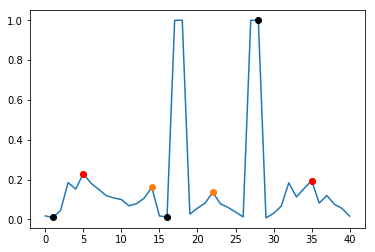

In [35]:
plt.plot(range(len(acc_norm)),acc_norm)
plt.plot(segs,acc_norm[segs],'o')
plt.plot(sega,acc_norm[sega],'or')
plt.plot(segb,acc_norm[segb],'ok')
plt.show()

In [ ]:
plt.plot(range(len(ja)),ja[:,:-1])
# plt.plot(segs,ja[segs,:-1],'o')
plt.plot(sega,ja[sega,:-1],'or')
plt.plot(segb,ja[segb,:-1],'ok')
plt.show()

In [26]:
segs, sega
import copy
csegs = copy.deepcopy(segs)
csegs = np.insert(csegs,0,0)
csegs = np.insert(csegs,len(csegs),ja.shape[0])
csegs

[ 5 14 22 35]


array([ 0,  5, 14, 22, 35, 43])

In [ ]:
# # Create Skill Network model. 
# skillnet = PrimitiveDecoderKnownLength()
# trainer_object = Trainer()
# trainer_object.load_network(skillnet, 'pred', 
                           
# trainer_object.load_network(skillnet, 'pred', opts.num_pretrain_skillnet_epoch,
#                 network_dir='~/Research/Code/saved_models/' ,
#                 network_dir=os.path.join('',opts.pretrain_skillnet_name)
#                 module_name='decoder'
#             ))

In [7]:
# Load skill network model.
opts.n_state = 16
opts.gripper = True
skillnet_manager = TrainSkillNet.SkillNetworkManager(opts, dataset)
skillnet_manager.setup()
skillnet_manager.load_all_models("/private/home/tanmayshankar/Research/Code/saved_models/T42_startgoal_nofixed_botharms/Save_SkillModelepoch149")

Networks Setup.


**Evaluate Segmentation**  
1) Iterate through trajectories  
2) Compute segmentation via Find Peaks of acceleration norm  
3) Pass each segment through the SkillNet  
4) Concatenate predicted trajectories.  
5) Compute Sequence Alignment loss between predicted and original trajectories.   

In [ ]:
opts.train=False
alignment_losses = np.zeros((len(dataset)))
trajectory_lengths = np.zeros((len(dataset)))

for i in range(len(dataset)):
    
    if i%100==0:
        print("Trajectory:", i)
        
    # Get item from dataset.
    data_element = dataset[i]
    joint_traj = data_element['joint_angle_trajectory'][:,2:-1]
    left_trajectory = data_element['la_trajectory']
    right_trajectory = data_element['ra_trajectory']
    left_gripper = data_element['left_gripper'].reshape((-1,1))
    right_gripper = data_element['right_gripper'].reshape((-1,1))

    concatenated_trajectory = np.concatenate([left_trajectory,right_trajectory,left_gripper,right_gripper],axis=1)
        
    if joint_traj.shape[0]>0:
        
        # Compute Acc. norm of joint_trajectory without grippers, because of sudden change of norm.
        acceleration_norm = np.linalg.norm(np.diff(joint_traj,n=2,axis=0),axis=1)
        
        # Find peaks with minimum length = 8.
        peaks = find_peaks(acceleration_norm, distance=8)[0]
        
        # Add start and end to peaks. 
        segmentation = np.insert(peaks, 0, 0)
        segmentation = np.insert(segmentation, len(segmentation), joint_traj.shape[0])
        
        # Segment the trajectory.
        trajectory_segments = []
        predicted_trajectory_segments = []
        for j in range(len(segmentation)-1):
            
            # Retrieve trajectory segments of CONCATENATED_TRAJECTORY - arms and grippers.
            traj_seg = concatenated_trajectory[segmentation[j]:segmentation[j+1]]
            trajectory_segments.append(copy.deepcopy(traj_seg))
                        
            # Feed segments into the Skillnet. 
            pred_traj_seg = skillnet_manager.run_iteration(0, traj_seg, retrieve=False, for_viz=True)
            predicted_trajectory_segments.append(pred_traj_seg.clone().detach().cpu().numpy())
                        
        # Concatenate predictions. 
        predicted_trajectory = np.concatenate(predicted_trajectory_segments,axis=0)
        
        # Compute alignment loss.
        alignment_losses[i] = skillnet_manager.align_loss_fn(torch.from_numpy(predicted_trajectory).double().cuda(),torch.from_numpy(concatenated_trajectory).double().cuda())/concatenated_trajectory.shape[0]
        trajectory_lengths[i] = concatenated_trajectory.shape[0]

Trajectory: 0
Trajectory: 100
Trajectory: 200
Trajectory: 300
Trajectory: 400
Trajectory: 500
Trajectory: 600
Trajectory: 700
Trajectory: 800
Trajectory: 900
Trajectory: 1000
Trajectory: 1100
Trajectory: 1200
Trajectory: 1300
Trajectory: 1400
Trajectory: 1500
Trajectory: 1600
Trajectory: 1700
Trajectory: 1800
Trajectory: 1900
Trajectory: 2000
